In [2]:
import numpy as np
import pandas as pd
import collections
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import LinearSVC, SVC
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [187]:
import matplotlib
import matplotlib.pyplot as plt
def create_heatmap(values_array, title, save_file):
    y = ['identity', 'logistic', 'tanh', 'relu']
    x = ['lbfgs', 'sgd', 'adam']

#     balanced_accuracy = np.array([[0.763, 0.828, 0.839, 0.837],
#                         [0.604, 0.602, 0.601, 0.602]])

    fig, ax = plt.subplots()
    im = ax.imshow(values_array)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y)):
        for j in range(len(x)):
            text = ax.text(j, i, values_array[i, j],
                           ha="center", va="center", color="w")

    ax.set_title(title)
    ax.set_xlabel("Wartość parametru solver")
    ax.set_ylabel("Wartość parametru activation")
    fig.tight_layout()
    plt.show()
    fig.savefig("./rysunki/"+save_file )

# Zadanie 4

In [3]:
data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [22]:
classes_count = collections.Counter(y)
class_0_prc = classes_count[0]/(classes_count[1]+classes_count[0])
class_1_prc = 1 - class_0_prc
print("0: ", class_0_prc)
print("1: ", class_1_prc)
print(classes_count)

0:  0.0085
1:  0.9915
Counter({1: 9915, 0: 85})


In [23]:
collections.Counter(X.dtypes)
# wszystkie atrybuty liczbowe

Counter({dtype('float64'): 119})

In [24]:
mean_df = pd.DataFrame(X.mean())
std_df = pd.DataFrame(X.std())
min_df = pd.DataFrame(X.min())
max_df = pd.DataFrame(X.max())

mean_std_df = mean_df.merge(std_df, left_index=True, right_index=True)
mean_std_df["std/mean"] = mean_std_df['0_y']/mean_std_df["0_x"]
mean_std_min_df = mean_std_df.merge(min_df, left_index=True, right_index=True)
mean_std_min_max_df = mean_std_min_df.merge(max_df, left_index=True, right_index=True)

mean_std_min_max_df.columns = ['mean', "std", "std/mean", 'min', 'max']
pd.DataFrame.round(mean_std_min_max_df,decimals=4).to_csv("./data_desc.csv")
mean_std_min_max_df

,mean,std,std/mean,min,max
dissim,0.011819,0.002912,0.246400,0.002139,0.017899
el0,0.296353,0.141780,0.478415,0.101680,0.898320
el1,0.380823,0.121475,0.318980,0.029949,0.872700
el2,0.334800,0.101426,0.302947,0.023313,0.692270
el3,0.317038,0.092990,0.293308,0.012183,0.922540
...,...,...,...,...,...
stat72,5.739799,3.204834,0.558353,-1.240600,26.082000
stat73,5.944474,5.549983,0.933637,-1.646000,26.748000
stat74,5.745532,3.245858,0.564936,-1.228800,26.102000
stat75,6.324414,4.613063,0.729406,-1.134600,50.220000


In [30]:
collections.Counter(mean_std_min_max_df['max']>1)

Counter({False: 106, True: 13})

In [29]:
collections.Counter((mean_std_min_max_df['max']>=0.9) & (mean_std_min_max_df['max']<=1))

Counter({False: 109, True: 10})

In [6]:
sca = StandardScaler()
X_std = sca.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

mean_df = pd.DataFrame(X_std.mean())
std_df = pd.DataFrame(X_std.std())
min_df = pd.DataFrame(X_std.min())
max_df = pd.DataFrame(X_std.max())

mean_std_df = mean_df.merge(std_df, left_index=True, right_index=True)
mean_std_min_df = mean_std_df.merge(min_df, left_index=True, right_index=True)
mean_std_min_max_df = mean_std_min_df.merge(max_df, left_index=True, right_index=True)

mean_std_min_max_df.columns = ['mean', "std", 'min', 'max']
mean_std_min_max_df
pd.DataFrame.round(mean_std_min_max_df,decimals=4).to_csv("./data_std_desc.csv")
# mean_std_min_max_df

In [10]:
# Klasa większościowa to 0 ~74%. To byłaby trafność klasyfikatora Zero Rule.
y_pred = np.zeros(data.shape[0])
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))
print("balanced_accuracy_score: ", balanced_accuracy_score(y, y_pred, adjusted=False))

[[  85    0]
 [9915    0]]
              precision    recall  f1-score   support

           0       0.01      1.00      0.02        85
           1       0.00      0.00      0.00      9915

    accuracy                           0.01     10000
   macro avg       0.00      0.50      0.01     10000
weighted avg       0.00      0.01      0.00     10000

balanced_accuracy_score:  0.5


D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
sensitivity = 0/(0+3897)
specificity = 11103/(11103+0)
G_mean = pow(sensitivity*specificity,0.5)
G_mean # 0

0.0

# Zadanie 5

:  0.36840326536250967


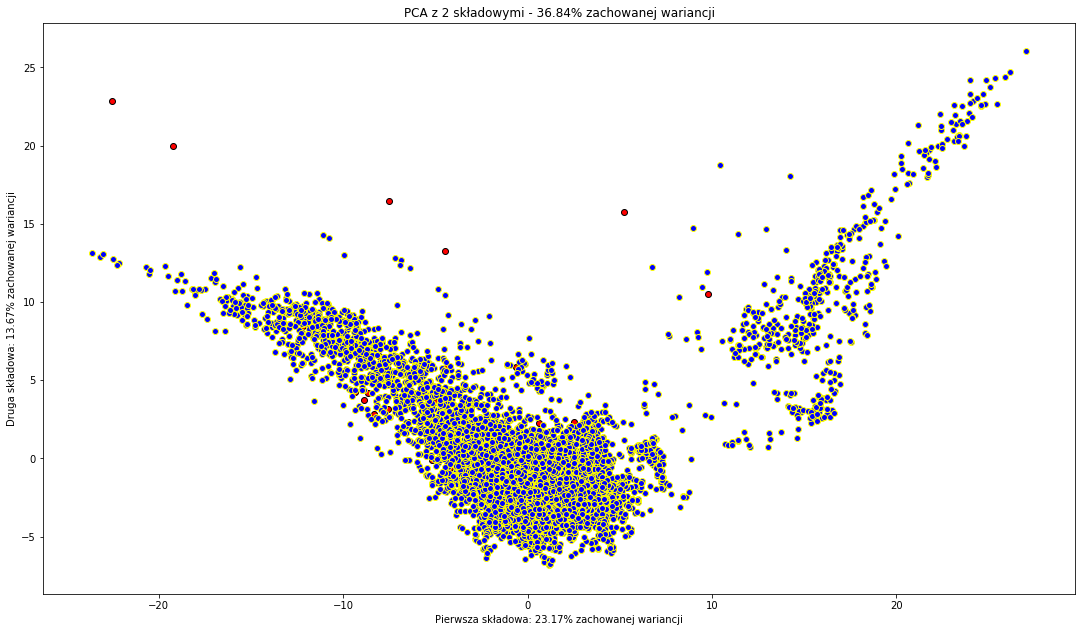

In [6]:
sca = StandardScaler()
X_std = sca.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.scatter(X_pca[y==0][:,0], X_pca[y==0][:,1], color='red', edgecolor='black')
plt.scatter(X_pca[y==1][:,0], X_pca[y==1][:,1], color='blue', edgecolor='yellow')

plt.xlabel("Pierwsza składowa: {0}% zachowanej wariancji".format(round(pca.explained_variance_ratio_[0]*100, 2)))
plt.ylabel("Druga składowa: {0}% zachowanej wariancji".format(round(pca.explained_variance_ratio_[1]*100, 2)))
plt.title("PCA z 2 składowymi - {0}% zachowanej wariancji".format(round(sum(pca.explained_variance_ratio_)*100, 2)))


# plt.savefig("./rysunki/PCA_2D.png")
print(": ", sum(pca.explained_variance_ratio_))

In [32]:
from matplotlib import interactive
%matplotlib qt  
# wx, gtk, osx, tk, empty uses default

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_std)[:15000]

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection='3d')
y_5k = y[:15000]
ax.scatter3D(X_pca[y_5k==0][:,0], X_pca[y_5k==0][:,1], X_pca[y_5k==0][:,2], color='red', edgecolor='black')
ax.scatter3D(X_pca[y_5k==1][:,0], X_pca[y_5k==1][:,1], X_pca[y_5k==1][:,2], color='blue', edgecolor='yellow')

ax.set_xlabel("Pierwsza składowa: {0}% zachowanej wariancji".format(round(pca.explained_variance_ratio_[0]*100, 2)))
ax.set_ylabel("Druga składowa: {0}% zachowanej wariancji".format(round(pca.explained_variance_ratio_[1]*100, 2)))
ax.set_zlabel("Trzecia składowa: {0}% zachowanej wariancji".format(round(pca.explained_variance_ratio_[2]*100, 2)))
plt.title("PCA z 3 składowymi - {0}% zachowanej wariancji".format(round(sum(pca.explained_variance_ratio_)*100, 2)))

# ax.view_init(10, 0)
# plt.savefig("./rysunki/PCA_3D.svg")
print(": ", sum(pca.explained_variance_ratio_))

:  0.44182075357276307


# Zadanie 7

In [45]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle

from imblearn.metrics import geometric_mean_score as gmean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
 

# Set the parameters by cross-validation
tuned_parameters = [{'clf': (KNeighborsClassifier(), )},
                   {'clf': (DecisionTreeClassifier(random_state=42), )},
                   {'clf': (RandomForestClassifier(random_state=42), )},
                   {'clf': (SVC(random_state=42), )},
                   {'clf': (MLPClassifier(random_state=42), )},
                   {'clf': (GaussianNB(), )},
                   {'clf': (QuadraticDiscriminantAnalysis(), )},]

# tuned_parameters = [{'clf': (KNeighborsClassifier(), )},
#                    {'clf': (DecisionTreeClassifier(random_state=42), )},]

scores_list = ['AUC', 'accuracy', 'gmean']
scoring = {'AUC': 'roc_auc',
           'accuracy': make_scorer(accuracy_score),
          'gmean': make_scorer(gmean)}

pipe = Pipeline(steps=[('clf',SVC(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       refit=score,
                       scoring=scoring,
                       cv=StratifiedKFold(n_splits=10, shuffle=True),
                      return_train_score=True)
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_{0}'.format(score)]
    stds = clf.cv_results_['std_test_{0}'.format(score)]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%s: %0.3f (+/-%0.03f) for %r"
              % (score, mean, std * 2, params))

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    pickle.dump(clf, open( score+"_BEZ_NORM.pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for AUC



D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

Best parameters set found on development set:

{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)}

Grid scores on development set:

AUC: 0.550 (+/-0.119) for {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')}
AUC: 0.604 (+/-0.071) for {'clf': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=N

D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Ma

Best parameters set found on development set:

{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)}

Grid scores on development set:

accuracy: 0.991 (+/-0.000) for {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')}
accuracy: 0.983 (+/-0.008) for {'clf': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       m

D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Ma

Best parameters set found on development set:

{'clf': GaussianNB(priors=None, var_smoothing=1e-09)}

Grid scores on development set:

gmean: 0.000 (+/-0.000) for {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')}
gmean: 0.360 (+/-0.525) for {'clf': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')}
gmean: 0.113 (+/-0.346) for {'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=

D:\Instalowane\Programy\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# Zadanie 8

In [53]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle

from imblearn.metrics import geometric_mean_score as gmean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
 

# Set the parameters by cross-validation
tuned_parameters = [{'clf': (KNeighborsClassifier(), )},
                   {'clf': (DecisionTreeClassifier(random_state=42), )},
                   {'clf': (RandomForestClassifier(random_state=42), )},
                   {'clf': (SVC(random_state=42), )},
                   {'clf': (MLPClassifier(random_state=42), )},
                   {'clf': (GaussianNB(), )},
                   {'clf': (QuadraticDiscriminantAnalysis(), )},]

# tuned_parameters = [{'clf': (KNeighborsClassifier(), )},
#                    {'clf': (DecisionTreeClassifier(random_state=42), )},]

scores_list = ['AUC', 'accuracy', 'gmean']
scoring = {'AUC': 'roc_auc',
           'accuracy': make_scorer(accuracy_score),
          'gmean': make_scorer(gmean)}

pipe = Pipeline(steps=[('scaler', StandardScaler()),('clf',SVC(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       refit=score,
                       scoring=scoring,
                       cv=StratifiedKFold(n_splits=10, shuffle=True),
                      return_train_score=True)
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_{0}'.format(score)]
    stds = clf.cv_results_['std_test_{0}'.format(score)]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%s: %0.3f (+/-%0.03f) for %r"
              % (score, mean, std, params))

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    pickle.dump(clf, open( score+"_STAND.pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for AUC

Best parameters set found on development set:

{'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)}

Grid scores on development set:

AUC: 0.566 (+/-0.111) for {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')}
AUC: 0.597 (+/-0.131) for {'clf': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                    

In [54]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle
from sklearn.preprocessing import PowerTransformer

from imblearn.metrics import geometric_mean_score as gmean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
 

# Set the parameters by cross-validation
tuned_parameters = [{'clf': (KNeighborsClassifier(), )},
                   {'clf': (DecisionTreeClassifier(random_state=42), )},
                   {'clf': (RandomForestClassifier(random_state=42), )},
                   {'clf': (SVC(random_state=42), )},
                   {'clf': (MLPClassifier(random_state=42), )},
                   {'clf': (GaussianNB(), )},
                   {'clf': (QuadraticDiscriminantAnalysis(), )},]

# tuned_parameters = [{'clf': (KNeighborsClassifier(), )},
#                    {'clf': (DecisionTreeClassifier(random_state=42), )},]

scores_list = ['AUC', 'accuracy', 'gmean']
scoring = {'AUC': 'roc_auc',
           'accuracy': make_scorer(accuracy_score),
          'gmean': make_scorer(gmean)}

pipe = Pipeline(steps=[('scaler', PowerTransformer()),('clf',SVC(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       refit=score,
                       scoring=scoring,
                       cv=StratifiedKFold(n_splits=10, shuffle=True),
 )
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_{0}'.format(score)]
    stds = clf.cv_results_['std_test_{0}'.format(score)]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%s: %0.3f (+/-%0.03f) for %r"
              % (score, mean, std, params))

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    pickle.dump(clf, open( score+"_POWER.pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for AUC

Best parameters set found on development set:

{'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)}

Grid scores on development set:

AUC: 0.586 (+/-0.091) for {'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')}
AUC: 0.639 (+/-0.143) for {'clf': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                    

In [61]:
file = open("gmean_STAND.pkl", "rb")
clf = pickle.load(file)
y_true, y_pred = y_test, clf.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[   7,    8],
       [ 303, 1682]], dtype=int64)

In [68]:
file = open("accuracy_STAND.pkl", "rb")
clf = pickle.load(file)
# print(clf.best_estimator_)
y_true, y_pred = y_test, clf.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[   4,   11],
       [   3, 1982]], dtype=int64)

# Zadanie 9

In [72]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle

from imblearn.metrics import geometric_mean_score as gmean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
 

# Set the parameters by cross-validation
tuned_parameters = {'clf__activation': ['identity', 'logistic', 'tanh', 'relu'],
                    'clf__solver': ['lbfgs', 'sgd', 'adam']}

scores_list = ['AUC', 'accuracy', 'gmean']
scoring = {'AUC': 'roc_auc',
           'accuracy': make_scorer(accuracy_score),
          'gmean': make_scorer(gmean)}

pipe = Pipeline(steps=[('scaler', StandardScaler()),('clf',MLPClassifier(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       refit=score,
                       scoring=scoring,
                       cv=StratifiedKFold(n_splits=10, shuffle=True),
                      return_train_score=True)
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_{0}'.format(score)]
    stds = clf.cv_results_['std_test_{0}'.format(score)]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%s: %0.3f (+/-%0.03f) for %r"
              % (score, mean, std, params))

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    pickle.dump(clf, open( score+"_BEST" + str(time.time()) +".pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for AUC

Best parameters set found on development set:

{'clf__activation': 'relu', 'clf__solver': 'adam'}

Grid scores on development set:

AUC: 0.816 (+/-0.080) for {'clf__activation': 'identity', 'clf__solver': 'lbfgs'}
AUC: 0.824 (+/-0.071) for {'clf__activation': 'identity', 'clf__solver': 'sgd'}
AUC: 0.816 (+/-0.078) for {'clf__activation': 'identity', 'clf__solver': 'adam'}
AUC: 0.763 (+/-0.100) for {'clf__activation': 'logistic', 'clf__solver': 'lbfgs'}
AUC: 0.562 (+/-0.070) for {'clf__activation': 'logistic', 'clf__solver': 'sgd'}
AUC: 0.806 (+/-0.103) for {'clf__activation': 'logistic', 'clf__solver': 'adam'}
AUC: 0.781 (+/-0.117) for {'clf__activation': 'tanh', 'clf__solver': 'lbfgs'}
AUC: 0.838 (+/-0.090) for {'clf__activation': 'tanh', 'clf__solver': 'sgd'}
AUC: 0.830 (+/-0.109) for {'clf__activation': 'tanh', 'clf__solver': 'adam'}
AUC: 0.811 (+/-0.094) for {'clf__activation': 'relu', 'clf__solver': 'lbfgs'}
AUC: 0.816 (+/-0.117) for {'clf__activ

In [171]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle

from imblearn.metrics import geometric_mean_score as gmean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
 

# Set the parameters by cross-validation
tuned_parameters = {'clf__activation': ['relu'],
                    'clf__solver': ['adam'],
                   'clf__max_iter': [200, 1000, 5000],
                   'clf__alpha':[0.000001, 0.0001, 0.1, 100]}

scores_list = ['AUC', 'accuracy', 'gmean']
scoring = {'AUC': 'roc_auc',
           'accuracy': make_scorer(accuracy_score),
          'gmean': make_scorer(gmean)}

pipe = Pipeline(steps=[('scaler', StandardScaler()),('clf',MLPClassifier(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       refit=score,
                       scoring=scoring,
                       cv=StratifiedKFold(n_splits=10, shuffle=True),
                      return_train_score=True)
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_{0}'.format(score)]
    stds = clf.cv_results_['std_test_{0}'.format(score)]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%s: %0.3f (+/-%0.03f) for %r"
              % (score, mean, std, params))

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    pickle.dump(clf, open( score+"_2_BEST_" + str(time.time()) +".pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for AUC

Best parameters set found on development set:

{'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__max_iter': 200, 'clf__solver': 'adam'}

Grid scores on development set:

AUC: 0.847 (+/-0.070) for {'clf__activation': 'relu', 'clf__alpha': 1e-06, 'clf__max_iter': 200, 'clf__solver': 'adam'}
AUC: 0.847 (+/-0.070) for {'clf__activation': 'relu', 'clf__alpha': 1e-06, 'clf__max_iter': 1000, 'clf__solver': 'adam'}
AUC: 0.847 (+/-0.070) for {'clf__activation': 'relu', 'clf__alpha': 1e-06, 'clf__max_iter': 5000, 'clf__solver': 'adam'}
AUC: 0.847 (+/-0.070) for {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__max_iter': 200, 'clf__solver': 'adam'}
AUC: 0.847 (+/-0.070) for {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__max_iter': 1000, 'clf__solver': 'adam'}
AUC: 0.847 (+/-0.070) for {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__max_iter': 5000, 'clf__solver': 'adam'}
AUC: 0.845 (+/-0.075) for {'clf__activation': 'relu', 'clf__al

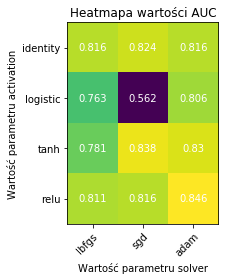

In [188]:
%matplotlib inline
# heatmapa activation-solver-AUC 
AUC = np.array([[0.816, 0.824, 0.816],
                    [0.763, 0.562, 0.806],
                    [0.781, 0.838, 0.830],
                    [0.811, 0.816, 0.846]])
create_heatmap(values_array=AUC,
              title="Heatmapa wartości AUC",
              save_file="zad9_heatmapa_AUC.png")

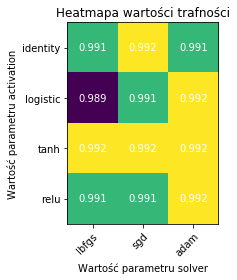

In [189]:
# heatmapa activation-solver-accuracy 
accuracy = np.array([[0.991, 0.992, 0.991],
                    [0.989, 0.991, 0.992],
                    [0.992, 0.992, 0.992],
                    [0.991, 0.991, 0.992]])
create_heatmap(values_array=accuracy,
              title="Heatmapa wartości trafności",
              save_file="zad9_heatmapa_accuracy.png")

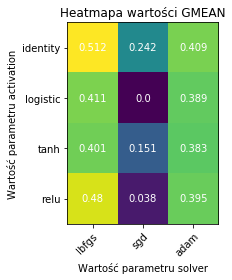

In [190]:
# heatmapa activation-solver-gmean 
gmean = np.array([[0.512, 0.242, 0.409],
                    [0.411, 0.000, 0.389],
                    [0.401, 0.151, 0.383],
                    [0.480, 0.038, 0.395]])
create_heatmap(values_array=gmean,
              title="Heatmapa wartości GMEAN",
              save_file="zad9_heatmapa_gmean.png")

# Zadanie 10

In [120]:
file = open("gmean_STAND.pkl", "rb")
clf = pickle.load(file)
# y_true, y_pred = y_test, clf.predict(X_test)
# confusion_matrix(y_true, y_pred)
clf.cv_results_

{'mean_fit_time': array([0.17780101, 1.60796094, 4.38225634, 0.79175088, 2.87879734,
        0.04248583, 0.0623328 ]),
 'std_fit_time': array([0.00865739, 0.1550799 , 0.17366434, 0.02779524, 0.15596471,
        0.00111021, 0.00261068]),
 'mean_score_time': array([2.27567909, 0.00397968, 0.0288276 , 0.14502831, 0.00787952,
        0.0048876 , 0.00678632]),
 'std_score_time': array([0.05807049, 0.00044393, 0.00070407, 0.00740706, 0.00082821,
        0.0006984 , 0.00059958]),
 'param_clf': masked_array(data=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
                    DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_

In [127]:
# entropy
clf = DecisionTreeClassifier(random_state=42,  criterion='entropy')
clf.fit(X_train, y_train)
imp = clf.feature_importances_.copy()
sorted_desc_index = np.argsort(imp)[::-1]

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
attributes = data.columns[:-1]
for i in range(10):
    index = sorted_desc_index[i]
    print("{} - {}".format(attributes[index], imp[index]))

stat14 - 0.1272713839933382
stat7 - 0.12422969451117419
stat20 - 0.05460586788848251
stat12 - 0.03901207372483918
stat11 - 0.0379820813739858
stat66 - 0.03786533916767583
stat24 - 0.035417988213770416
stat15 - 0.03334762051320418
stat32 - 0.029832979605985462
stat45 - 0.02870004775914598


In [129]:
# gini
clf = DecisionTreeClassifier(random_state=42,  criterion='gini')
clf.fit(X_train, y_train)
imp = clf.feature_importances_.copy()
sorted_desc_index = np.argsort(imp)[::-1]

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
attributes = data.columns[:-1]
for i in range(10):
    index = sorted_desc_index[i]
    print("{} - {}".format(attributes[index], imp[index]))

stat8 - 0.12573095941089615
stat54 - 0.05470070306133859
stat14 - 0.05312814356263773
stat13 - 0.050096257712578515
stat15 - 0.04887084332229356
stat22 - 0.04562165187559479
stat25 - 0.03904785775267401
stat6 - 0.03857587774404684
stat19 - 0.03741388187773583
el22 - 0.036511704303411156


# Zadanie 11

In [169]:
data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

zero_to_all_ratio = collections.Counter(y_train)[0]/len(y_train)
class_weights = [None,
                 {0:1, 1:1}, 
                 'balanced',
                 {0:(1-zero_to_all_ratio), 1:zero_to_all_ratio},
                 {0:0.75, 1:25},
                 {0:zero_to_all_ratio, 1:(1-zero_to_all_ratio)}
                ]
for class_weight in class_weights:
    clf = DecisionTreeClassifier(random_state=42,  
                                 criterion='gini',
                                class_weight=class_weight)

    pipe = Pipeline(steps=[('scaler', StandardScaler()),('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print('===================================')
    print(class_weight)
    print(confusion_matrix(y_test, y_pred))

None
[[   0   15]
 [  17 1968]]
{0: 1, 1: 1}
[[   0   15]
 [  17 1968]]
balanced
[[   3   12]
 [  16 1969]]
{0: 0.99125, 1: 0.00875}
[[   3   12]
 [  12 1973]]
{0: 0.75, 1: 25}
[[   3   12]
 [  29 1956]]
{0: 0.25, 1: 75}
[[   3   12]
 [  29 1956]]
{0: 0.00875, 1: 0.99125}
[[   3   12]
 [  25 1960]]


# Zadanie 12 - najlepszy model MLPClassifier(solver='adam', activation='relu')

In [191]:
# ze standaryzacją
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle

from imblearn.metrics import geometric_mean_score as gmean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
 

# Set the parameters by cross-validation
tuned_parameters = {'clf': [MLPClassifier(random_state=42)],
                    'clf__activation': ['relu'],
                    'clf__solver': ['adam']}

scores_list = ['AUC', 'accuracy', 'gmean']
scoring = {'AUC': 'roc_auc',
           'accuracy': make_scorer(accuracy_score),
          'gmean': make_scorer(gmean)}

pipe = Pipeline(steps=[('scaler', StandardScaler()),('clf',MLPClassifier(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       refit=score,
                       scoring=scoring,
                       cv=StratifiedKFold(n_splits=10, shuffle=True),
                      return_train_score=True)
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_{0}'.format(score)]
    stds = clf.cv_results_['std_test_{0}'.format(score)]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%s: %0.3f (+/-%0.03f) for %r"
              % (score, mean, std, params))

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
#     pickle.dump(clf, open( score+"_2_BEST_" + str(time.time()) +".pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for AUC

Best parameters set found on development set:

{'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), 'clf__activation': 'relu', 'clf__solver': 'adam'}

Grid scores on development set:

AUC: 0.838 (+/-0.120) for {'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, ma

In [192]:
# bez standaryzacji
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle

from imblearn.metrics import geometric_mean_score as gmean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
 

# Set the parameters by cross-validation
tuned_parameters = {'clf': [MLPClassifier(random_state=42)],
                    'clf__activation': ['relu'],
                    'clf__solver': ['adam']}

scores_list = ['AUC', 'accuracy', 'gmean']
scoring = {'AUC': 'roc_auc',
           'accuracy': make_scorer(accuracy_score),
          'gmean': make_scorer(gmean)}

pipe = Pipeline(steps=[('clf',MLPClassifier(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       refit=score,
                       scoring=scoring,
                       cv=StratifiedKFold(n_splits=10, shuffle=True),
                      return_train_score=True)
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_{0}'.format(score)]
    stds = clf.cv_results_['std_test_{0}'.format(score)]
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%s: %0.3f (+/-%0.03f) for %r"
              % (score, mean, std, params))

    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
#     pickle.dump(clf, open( score+"_2_BEST_" + str(time.time()) +".pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for AUC

Best parameters set found on development set:

{'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), 'clf__activation': 'relu', 'clf__solver': 'adam'}

Grid scores on development set:

AUC: 0.759 (+/-0.055) for {'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, ma

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)


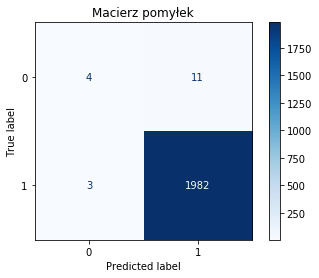

In [197]:
# macierz pomyłek
clf = pickle.load(open("./auc_BEST.pkl", 'rb'))

best = clf.best_estimator_
print(best)

data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

y_pred = best.predict(X_test)

disp = plot_confusion_matrix(best, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues, 
                                 values_format='d')

disp.ax_.set_title("Macierz pomyłek")
plt.savefig('./rysunki/zad12_confusion_matrix_BEST.png')

plt.show()

In [170]:
data = pd.read_csv("./131767-imbalanced.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

zero_to_all_ratio = collections.Counter(y_train)[0]/len(y_train)
class_weights = [None,
                 {0:1, 1:1}, 
                 'balanced',
                 {0:(1-zero_to_all_ratio), 1:zero_to_all_ratio},
                 {0:0.75, 1:25},
                 {0:zero_to_all_ratio, 1:(1-zero_to_all_ratio)},
                ]
for class_weight in class_weights:
    clf = SVC(random_state=42,  
              class_weight=class_weight)

    pipe = Pipeline(steps=[('scaler', StandardScaler()),('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print('===================================')
    print(class_weight)
    print(confusion_matrix(y_test, y_pred))

None
[[   0   15]
 [   0 1985]]
{0: 1, 1: 1}
[[   0   15]
 [   0 1985]]
balanced
[[   5   10]
 [   5 1980]]
{0: 0.99125, 1: 0.00875}
[[  10    5]
 [ 241 1744]]
{0: 0.75, 1: 25}
[[   0   15]
 [   0 1985]]
{0: 0.25, 1: 75}
[[   0   15]
 [   0 1985]]
{0: 0.00875, 1: 0.99125}
[[   0   15]
 [   0 1985]]


In [165]:
collections.Counter(y_train)

Counter({1: 7930, 0: 70})

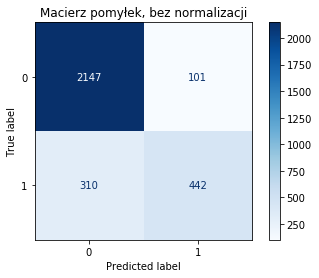

In [103]:
# best estimator
clf_acc = pickle.load(open("./accuracy_BEZ_LINEAR.pkl", 'rb'))
clf_bal_acc = pickle.load(open("./balanced_accuracy_BEZ_LINEAR.pkl", 'rb'))

best_acc = clf_acc.best_estimator_
best_bal_acc = clf_bal_acc.best_estimator_

data = pd.read_csv("./131767-svm.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

y_pred = best_acc.predict(X_test)
# print('accuracy')
# print(confusion_matrix(y_test, y_pred))

y_pred = best_bal_acc.predict(X_test)
# print('balanced accuracy')
# print(confusion_matrix(y_test, y_pred))

# titles_options = [("Macierz pomyłek, bez normalizacji", None),
#                   ("Macierz pomyłek, z normalizacją", 'true'),
#                  ("Macierz pomyłek, ze standaryzacją", 'true')]

disp = plot_confusion_matrix(best_acc, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues, 
                                 values_format='d')

disp.ax_.set_title("Macierz pomyłek, bez normalizacji")
plt.savefig('./rysunki/zad8_confusion_matrix_BEZ_NORM.png')

plt.show()

# Zadanie 10

In [42]:
# NORMALIZACJA
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle
from sklearn.preprocessing import Normalizer, StandardScaler

data = pd.read_csv("./131767-svm.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


# Set the parameters by cross-validation
tuned_parameters = {'svc__kernel':('rbf', 'sigmoid'),
              'svc__C':[1, 10, 100, 1000],
            'svc__class_weight':['balanced']}

scores_list = ['accuracy', 'balanced_accuracy']
pipe = Pipeline(steps=[('scaler', Normalizer()), ('svc',SVC(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       scoring=score,
                       cv=StratifiedKFold(n_splits=10, shuffle=True))
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    pickle.dump(clf, open( score+str(time.time())+"BEZ_LINEAR_NORM_BALANCED_SHUFFLE_PIPE.pkl", "wb" ) )

    
print(time.time()-start)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'svc__C': 1000, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf'}

Grid scores on development set:

0.780 (+/-0.034) for {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf'}
0.429 (+/-0.026) for {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__kernel': 'sigmoid'}
0.794 (+/-0.026) for {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf'}
0.421 (+/-0.026) for {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__kernel': 'sigmoid'}
0.805 (+/-0.026) for {'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf'}
0.421 (+/-0.027) for {'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__kernel': 'sigmoid'}
0.821 (+/-0.027) for {'svc__C': 1000, 'svc__class_weight': 'balanced', 'svc__kernel': 'rbf'}
0.421 (+/-0.027) for {'svc__C': 1000, 'svc__class_weight': 'balanced', 'svc__kernel': 'sigmoid'}

Detailed classification report:

The model is trained on t

In [48]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
y_true, y_pred = y_test, clf.predict(X_test)
print(accuracy_score(y_true, y_pred))
print(balanced_accuracy_score(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

# 0.958 - specifity
# 0.527 - sensivity - recall

0.8503333333333334
0.7430552926478383
[[2154   94]
 [ 355  397]]


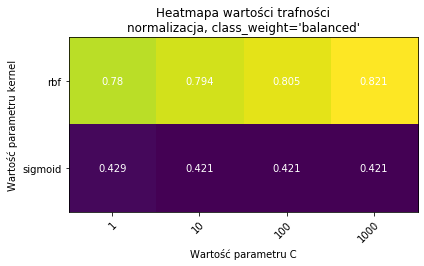

In [88]:
# heatmapa accuracy - NORMALIZACJA, BALANCED
accuracy = np.array([[0.780, 0.794, 0.805, 0.821],
                    [0.429, 0.421, 0.421, 0.421]])
create_heatmap(values_array=accuracy,
              title="Heatmapa wartości trafności",
               param="normalizacja, class_weight='balanced'",
              save_file="zad10_heatmapa_acc_NORM_BALANCED.png")

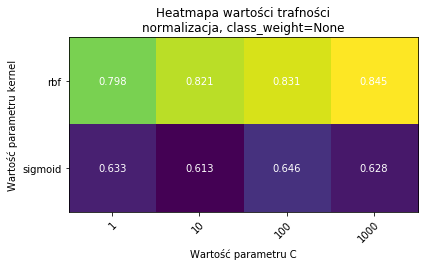

In [90]:
# heatmapa accuracy - NORMALIZACJA, NONE
accuracy = np.array([[0.798, 0.821, 0.831, 0.845],
                    [0.633, 0.613, 0.646, 0.628]])
create_heatmap(values_array=accuracy,
              title="Heatmapa wartości trafności",
               param='normalizacja, class_weight=None',
              save_file="zad10_heatmapa_acc_NORM_None.png")

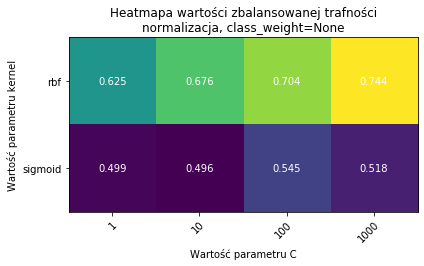

In [92]:
#############
# heatmapa balanced_accuracy - NORMALIZACJA, None
balanced_accuracy = np.array([[0.625, 0.676, 0.704, 0.744],
                    [0.499, 0.496, 0.545, 0.518]])
create_heatmap(values_array=balanced_accuracy,
              title="Heatmapa wartości zbalansowanej trafności",
               param="normalizacja, class_weight=None",
              save_file="zad10_heatmapa_bal_acc_NORM_None.png")

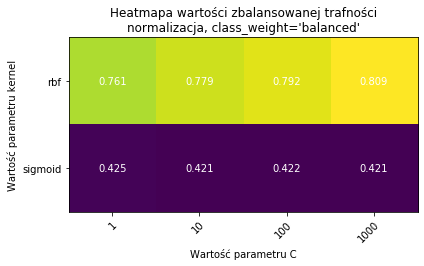

In [99]:
# heatmapa balanced_accuracy - NORMALIZACJA, BALANCED
balanced_accuracy = np.array([[0.761, 0.779, 0.792, 0.809],
                    [0.425, 0.421, 0.422, 0.421]])
create_heatmap(values_array=balanced_accuracy,
              title="Heatmapa wartości zbalansowanej trafności",
               param="normalizacja, class_weight='balanced'",
              save_file="zad10_heatmapa_bal_acc_NORM_BALANCED.png")

accuracy
[[2154   94]
 [ 355  397]]
balanced accuracy
[[2154   94]
 [ 355  397]]


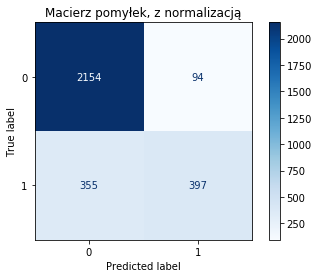

In [106]:
# best estimator 
clf_acc = pickle.load(open("./pkl_z_pipeline/accuracy_BEZ_LINEAR_NORM_None_PIPE.pkl", 'rb'))
clf_bal_acc = pickle.load(open("./balanced_accuracy_BEZ_LINEAR_NORM.pkl", 'rb'))

best_acc = clf_acc.best_estimator_
best_bal_acc = clf_bal_acc.best_estimator_

data = pd.read_csv("./131767-svm.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

norm = Normalizer()
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

y_pred = best_acc.predict(X_test)
print('accuracy')
print(confusion_matrix(y_test, y_pred))

y_pred = best_bal_acc.predict(X_test)
print('balanced accuracy')
print(confusion_matrix(y_test, y_pred))

disp = plot_confusion_matrix(best_acc, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues, 
                                 values_format='d')

disp.ax_.set_title("Macierz pomyłek, z normalizacją")
plt.savefig('./rysunki/zad10_confusion_matrix_NORM_NONE.png')

plt.show()

accuracy
[[2154   94]
 [ 355  397]]
balanced accuracy
[[2154   94]
 [ 355  397]]


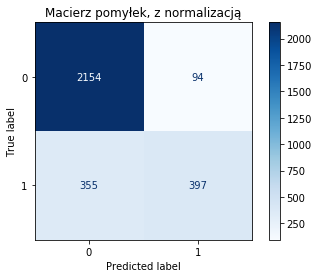

In [113]:
# best estimator Z SHUFFLE
clf_acc = pickle.load(open("./pkl_z_pipeline/accuracy_BEZ_LINEAR_NORM_None_SHUFFLE_PIPE.pkl", 'rb'))
clf_bal_acc = pickle.load(open("./balanced_accuracy_BEZ_LINEAR_NORM.pkl", 'rb'))

best_acc = clf_acc.best_estimator_
best_bal_acc = clf_bal_acc.best_estimator_

data = pd.read_csv("./131767-svm.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

norm = Normalizer()
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

y_pred = best_acc.predict(X_test)
print('accuracy')
print(confusion_matrix(y_test, y_pred))

y_pred = best_bal_acc.predict(X_test)
print('balanced accuracy')
print(confusion_matrix(y_test, y_pred))

disp = plot_confusion_matrix(best_acc, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues, 
                                 values_format='d')

disp.ax_.set_title("Macierz pomyłek, z normalizacją")
plt.savefig('./rysunki/zad10_confusion_matrix_NORM_NONE_SHUFFLE.png')

plt.show()

In [44]:
# STANDARYZACJA
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
import time
import pickle
from sklearn.preprocessing import Normalizer, StandardScaler

data = pd.read_csv("./131767-svm.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# sca = StandardScaler()
# X_train = sca.fit_transform(X_train)
# X_test = sca.transform(X_test)


# Set the parameters by cross-validation
tuned_parameters = {'svc__kernel':('rbf', 'sigmoid'),
              'svc__C':[1, 10, 100, 1000],
            'svc__class_weight':[None]}

scores_list = ['accuracy', 'balanced_accuracy']
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc',SVC(random_state=42))])

start = time.time()
for score in scores_list:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipe, 
                       tuned_parameters, 
                       scoring=score,
                       cv=StratifiedKFold(n_splits=10, shuffle=True))
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    pickle.dump(clf, open( score+str(time.time())+"BEZ_LINEAR_STAND_None_SHUFFLE_PIPE.pkl", "wb" ) )
    
print(time.time()-start)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'svc__C': 10, 'svc__class_weight': None, 'svc__kernel': 'rbf'}

Grid scores on development set:

0.860 (+/-0.021) for {'svc__C': 1, 'svc__class_weight': None, 'svc__kernel': 'rbf'}
0.696 (+/-0.022) for {'svc__C': 1, 'svc__class_weight': None, 'svc__kernel': 'sigmoid'}
0.887 (+/-0.015) for {'svc__C': 10, 'svc__class_weight': None, 'svc__kernel': 'rbf'}
0.693 (+/-0.021) for {'svc__C': 10, 'svc__class_weight': None, 'svc__kernel': 'sigmoid'}
0.883 (+/-0.013) for {'svc__C': 100, 'svc__class_weight': None, 'svc__kernel': 'rbf'}
0.693 (+/-0.021) for {'svc__C': 100, 'svc__class_weight': None, 'svc__kernel': 'sigmoid'}
0.882 (+/-0.012) for {'svc__C': 1000, 'svc__class_weight': None, 'svc__kernel': 'rbf'}
0.693 (+/-0.020) for {'svc__C': 1000, 'svc__class_weight': None, 'svc__kernel': 'sigmoid'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the 

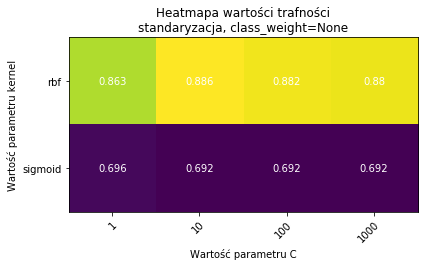

In [97]:
# heatmapa accuracy - STANDARYZACJA, NONE
accuracy = np.array([[0.863, 0.886, 0.882, 0.880],
                    [0.696, 0.692, 0.692, 0.692]])
create_heatmap(values_array=accuracy,
              title="Heatmapa wartości trafności",
               param="standaryzacja, class_weight=None",
              save_file="zad10_heatmapa_acc_STAND_NONE.png")

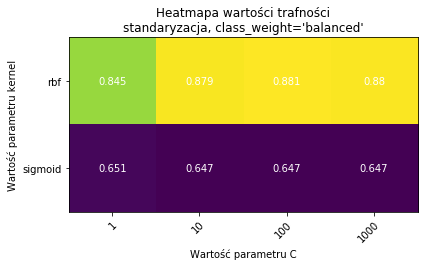

In [94]:
# heatmapa accuracy - STANDARYZACJA, BALANCED
accuracy = np.array([[0.845, 0.879, 0.881, 0.880],
                    [0.651, 0.647, 0.647, 0.647]])
create_heatmap(values_array=accuracy,
              title="Heatmapa wartości trafności",
               param="standaryzacja, class_weight='balanced'",
              save_file="zad10_heatmapa_acc_STAND_BALANCED.png")

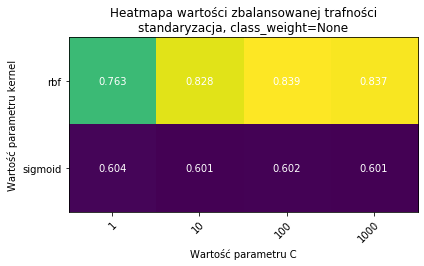

In [95]:
# heatmapa balanced_accuracy - STANDARYZACJA, NONE
balanced_accuracy = np.array([[0.763, 0.828, 0.839, 0.837],
                    [0.604, 0.601, 0.602, 0.601]])
create_heatmap(values_array=balanced_accuracy,
              title="Heatmapa wartości zbalansowanej trafności",
               param="standaryzacja, class_weight=None",
              save_file="zad10_heatmapa_bal_acc_STAND_NONE.png")

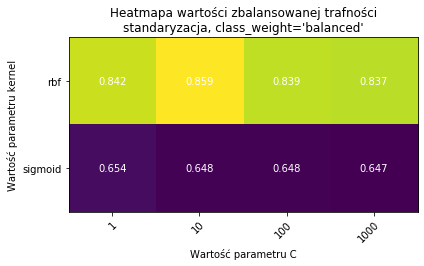

In [96]:
# heatmapa balanced_accuracy - STANDARYZACJA, BALANCED
balanced_accuracy = np.array([[0.842, 0.859, 0.839, 0.837],
                    [0.654, 0.648, 0.648, 0.647]])
create_heatmap(values_array=balanced_accuracy,
              title="Heatmapa wartości zbalansowanej trafności",
               param="standaryzacja, class_weight='balanced'",
              save_file="zad10_heatmapa_bal_acc_STAND_BALANCED.png")

accuracy
[[2130  118]
 [ 209  543]]
balanced accuracy
[[2092  156]
 [ 180  572]]


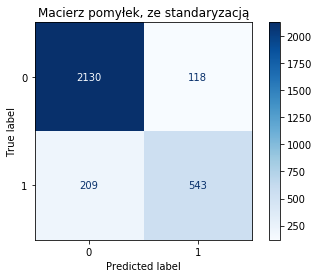

In [108]:
# best estimator 
clf_acc = pickle.load(open("./accuracy_BEZ_LINEAR_STAND.pkl", 'rb'))
clf_bal_acc = pickle.load(open("./balanced_accuracy_BEZ_LINEAR_STAND.pkl", 'rb'))


best_acc = clf_acc.best_estimator_
best_bal_acc = clf_bal_acc.best_estimator_

data = pd.read_csv("./131767-svm.txt", sep='\t')
data[:3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

sca = StandardScaler()
X_train = sca.fit_transform(X_train)
X_test = sca.transform(X_test)

y_pred = best_acc.predict(X_test)
print('accuracy')
print(confusion_matrix(y_test, y_pred))

y_pred = best_bal_acc.predict(X_test)
print('balanced accuracy')
print(confusion_matrix(y_test, y_pred))

disp = plot_confusion_matrix(best_acc, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues, 
                                 values_format='d')

disp.ax_.set_title("Macierz pomyłek, ze standaryzacją")
plt.savefig('./rysunki/zad10_confusion_matrix_STAND_NONE.png')

plt.show()

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score as gmean
from skleanr.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
clf = SVC(random_state=42)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("balanced_accuracy_score: ", balanced_accuracy_score(y_test, y_pred, adjusted=False))
print(gmean(y_test, y_pred))

In [ ]:
# standarycja, bez użycia PCA
sca = StandardScaler()
X_train_std = sca.fit_transform(X_train)
X_test_std = sca.transform(X_test)

clf = LinearSVC(random_state=42)
clf.fit(X_train_std, y_train)


y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))
print("balanced_accuracy_score: ", balanced_accuracy_score(y_test, y_pred, adjusted=False))

In [ ]:
# standaryzacja, PCA 3 wymiary
sca = StandardScaler()
X_train_std = sca.fit_transform(X_train)
X_test_std = sca.transform(X_test)

pca = PCA(n_components=119, random_state=42)
X_train_std_pca = pca.fit_transform(X_train_std)
X_test_std_pca = pca.transform(X_test_std)
print("explained_variance_ratio_: ", sum(pca.explained_variance_ratio_))

clf = SVC(random_state=42)
clf.fit(X_train_std_pca, y_train)


y_pred = clf.predict(X_test_std_pca)
print(classification_report(y_test, y_pred))
print("balanced_accuracy_score: ", balanced_accuracy_score(y_test, y_pred, adjusted=False))

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

In [ ]:
clf.cv_results_

In [52]:
import json
id = 1
username = 'maciej'
password = "sdfsffsd"

f = {"id": id, "username": username, "password": password}
jsonify(f)

NameError: name 'jsonify' is not defined